# **Classification: Part 2 Practice**



### Data Preparation

In [1]:
# preparation of the dataset from Chapter 5
import pandas as pd

data = pd.read_csv("Full-Economic-News-DFE.csv" , encoding = "ISO-8859-1")

display(data.shape) # Number of rows (instances) and columns in the dataset
data["relevance"].value_counts() # Class distribution in the dataset

(8000, 15)

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

In [2]:
data = data.loc[data['relevance'] != 'not sure']

In [3]:
import string
import sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in ENGLISH_STOP_WORDS])
    # remove punctuation and numbers
    return doc

In [4]:
X = data.text # the column text contains textual data to extract features from
y = data.relevance # this is the column we are learning to predict.
print(X.shape, y.shape)
type(X)

(7991,) (7991,)


pandas.core.series.Series

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5993,) (5993,)
(1998,) (1998,)


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean, max_features=500) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 500) (1998, 500)


### Oversampling

In [7]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate sampling object
# create an instance of RandomOverSampler with the desired sampling_strategy
ros = RandomOverSampler(sampling_strategy="minority")

# Fit RandomOverSampler to the training data
X_resampled, y_resampled = ros.fit_resample(X_train_dtm, y_train)
y_resampled.value_counts()

no     4928
yes    4928
Name: relevance, dtype: int64

### Model Training

Simple hold out validation when training a Decision tree model.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Initialize a decision tree classifier
clf = DecisionTreeClassifier(max_depth=3)

# Train the decision tree classifier
clf.fit(X_resampled, y_resampled)

# Use the trained classifier to predict the labels of the testing data
y_pred = clf.predict(X_test_dtm)

# Evaluate the accuracy of the predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6281281281281281
              precision    recall  f1-score   support

          no       0.89      0.63      0.73      1643
         yes       0.27      0.64      0.38       355

    accuracy                           0.63      1998
   macro avg       0.58      0.63      0.56      1998
weighted avg       0.78      0.63      0.67      1998



The parameter max_depth for a decision tree is a hyperparameter that specifies the maximum depth of the tree. A smaller max_depth will result in a simpler model that is less prone to overfitting but may have higher bias. A larger max_depth will allow the model to capture more complex interactions between the features and the target variable but may result in overfitting and poor generalization performance on new datasets.

**What have we added to the training of the Decision Tree model below?**

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

param_grid = {
    'max_depth': [2, 3, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Define the decision tree classifier
dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid=param_grid, cv=5)
grid_search.fit(X_train_dtm, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test_dtm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best cross-validation score:  0.8229598677807466
Accuracy: 0.8173173173173173
              precision    recall  f1-score   support

          no       0.82      0.99      0.90      1643
         yes       0.32      0.03      0.05       355

    accuracy                           0.82      1998
   macro avg       0.57      0.51      0.47      1998
weighted avg       0.74      0.82      0.75      1998



**What have we changed below and why?**

In [10]:
import numpy as np
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer

# Define the hyperparameters to tune
param_grid = {
    'decisiontreeclassifier__max_depth': [2, 4, 6, 8, 10],
    'decisiontreeclassifier__min_samples_split': [2, 4, 6, 8, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5]
}

# Define the decision tree classifier
dt = DecisionTreeClassifier()

# Define the oversampler
oversampler = RandomOverSampler(sampling_strategy="minority")


# Define the pipeline to include the vectorizer, oversampler, and decision tree classifier
pipeline = make_pipeline(oversampler, dt)

# Define the inner cross-validation loop
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested cross-validation with hyperparameter tuning and oversampling
precision_scores = []
recall_scores = []
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, y_train = X.values[train_idx], y.values[train_idx]
    X_test, y_test = X.values[test_idx], y.values[test_idx]

    vect = CountVectorizer(preprocessor=clean, max_features=1000)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv)
    grid_search.fit(X_train_dtm, y_train)

    best_dt = grid_search.best_estimator_
    y_pred = best_dt.predict(X_test_dtm)

    # Calculate the precision and recall on the testing data and store them
    precision = precision_score(y_test, y_pred, pos_label="yes")
    recall = recall_score(y_test, y_pred, pos_label="yes")
    precision_scores.append(precision)
    recall_scores.append(recall)

# Print the mean precision and recall scores and their standard deviations
print("Mean precision:", np.mean(precision_scores))
print("Standard deviation:", np.std(precision_scores))
print("Mean recall:", np.mean(recall_scores))
print("Standard deviation:", np.std(recall_scores))


Mean precision: 0.2958521860157247
Standard deviation: 0.013433754441669776
Mean recall: 0.5626760563380282
Standard deviation: 0.056531358423632334


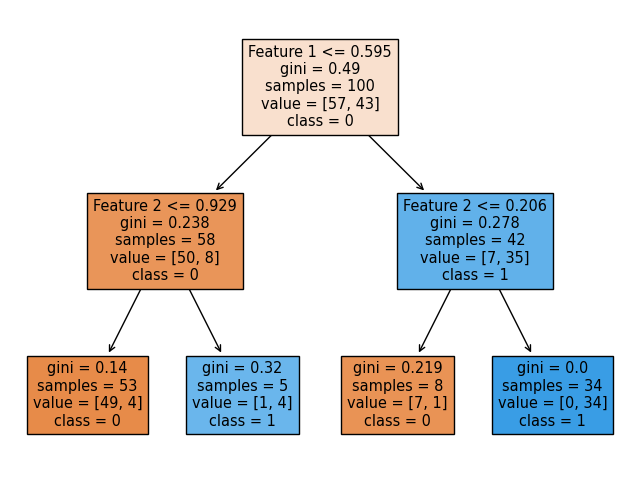

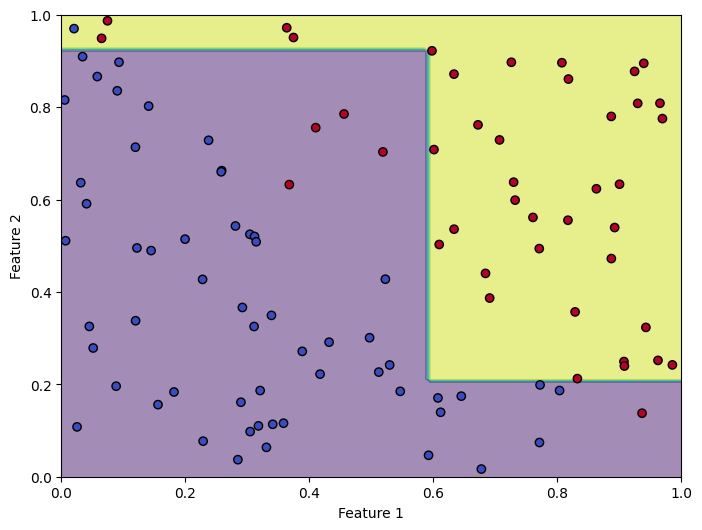

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Generate random data
np.random.seed(42)
X = np.random.rand(100, 2)
y = np.zeros(100)
y[np.where(X[:,0] + X[:,1] > 1)] = 1

# Fit decision tree
clf = DecisionTreeClassifier(max_depth=2, max_features=2)
clf.fit(X, y)

# Plot decision tree
fig, ax = plt.subplots(figsize=(8,6))
tree.plot_tree(clf, feature_names=['Feature 1', 'Feature 2'], class_names=['0', '1'], filled=True)
plt.show()

# Plot data points and decision boundary
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8,6))
ax.contourf(xx, yy, Z, alpha=0.5)
ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolors='k')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()